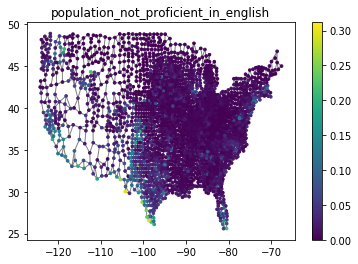

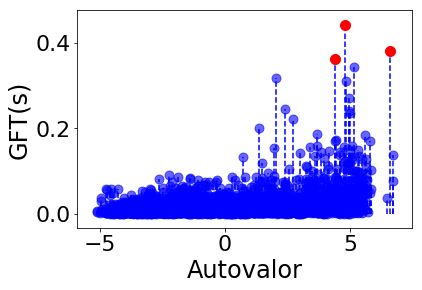

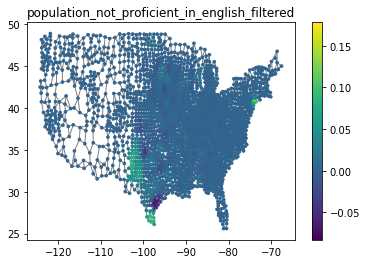

In [50]:
# Desenvolvido em python (jupyter)

#
# Neste código são plotados vértices (coloridos de acordo com o valor do sinal atribuído) e arestas de um grafo bidirecional 
# Cada vértice representa um condado dos EUA e as arestas são ponderadas usando a distância euclideana como parâmetro
# principal. 

# Para que o código funcione é precio instalar as bibliotecas abaixo. 

###
import csv
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from pygsp import *
from gspy import *

###
# Abrindo o arquivo csv com os dados necessários e armazenando os valores numa matriz para trabalhar com os dados no
# código. O arquivo csv neste caso é o baixado diretamente do datausa.io.
columns_signal = defaultdict(list) 

with open('population_not_proficient_in_english.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        for (i,v) in enumerate(row):
            columns_signal[i].append(v)
            

l = len(columns_signal[0])

###
# Abrindo o arquivo csv com os dados necessários e armazenando os valores numa matriz para trabalhar com os dados no
# código. O arquivo csv neste caso contém a identificação, latitude e longitude de cada condado.
columns_fips = defaultdict(list) 

with open('fips_lat_long.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        for (i,v) in enumerate(row):
            columns_fips[i].append(v)
            

k = len(columns_fips[0])

# Agora cria-se uma matriz que vai armazenar a identificação, latitude, longitude e sinal para cada condado. 
# A ideia é usar uma substring para armazenar a identificação do condado encontrado no arquivo do datausa.io 
# e em seguida buscar no arquivo fips_lat_long.csv. Caso a identificação coincida com algum condado do arquivo 
# anterior, verifica-se a latitude e longitude para que condados do Alaska e do Hawaii não sejam levados em conta. 

###
# Variável auxiliar usada para indexar corretamente os elementos de B[][]
aux = 0

# Matriz para armazenar os dados desejados. B[][0] contém o FIPS, B[][1] contém a latitude, B[][2] a longitude
# e B[][3] o sinal
B = np.zeros((l,4))

for i in range (0,l):

# "a" é a substring contendo a identificação    
    a = columns_signal[2][i]
    a = a[-5:]
    
# Processo de busca    
    for j in range (0,k):
        
        if (a == columns_fips[0][j] and float(columns_fips[2][j]) < -64.0 and float(columns_fips[2][j]) > -127.0):
# Em caso de não existir valor atribuído a um condado, tira-se print do índice do sinal e nada é armazenado em B[][]             
            try:
                B[aux][0] = columns_fips[0][j]
                B[aux][1] = columns_fips[1][j]
                B[aux][2] = columns_fips[2][j]
                B[aux][3] = float(columns_signal[3][i])
            except ValueError:
                print (i)        
                break

            aux = aux + 1

# B[][] é criada com dimensões do arquivo do datausa.io. Sendo assim, caso ocorram "FIPS" que não são encontrados
# no outro arquivo, haverão linhas nulas. O código abaixo serve para remover tais linhas.
B = B[~np.all(B == 0, axis=1)]

    
# É preciso criar uma matriz com duas colunas para as coordenadas e um vetor coluna para o sinal

###
coords = np.zeros((len(B),2))
s = np.zeros((len(B),1))

for p in range(0,len(B)):
    coords[p][1] = B[p][1]
    coords[p][0] = B[p][2]
    s[p] = B[p][3]
    
###
# Criando matriz de adjacência usando a biblioteca gspy
A = adj_matrix_from_coords_limited(coords,3)

# Definindo o grafo por meio da matriz de adjacência

G = graphs.Graph(A)

# Setando as coordenadas dos nós

G.set_coordinates(coords)

# Plota-se agora os nós nas devidas coordenadas com os respectivos sinais e as arestas ponderadas anteriormente
# por meio da biblioteca gspy

plotting.plot_signal(G, s, vertex_size = 7, plot_name = 'population_not_proficient_in_english',save_as = 'population_not_proficient_in_english')


# Constantes dos parâmetros da função utilizada para plotar a GFT
fsize = 24 # plot axis font size
msize = 14 # marker size
csize = fsize - 2 # colorbar label size
graph_node_size = 80

# Calcula-se as matrizes de autovalores e de autovetores
[eigvals,V] = np.linalg.eig(A)

# Calcula-se a inversa da matriz de autovetores 
Vinv = np.linalg.inv(V)

# Encontra-se o autovalor de maior módulo
eigval_abs_max = np.max(np.abs(eigvals))

# Calcula-se a GFT pelo produto matricial abaixo
ss = np.dot(Vinv,s) #GFT

# Cada autovalor é subtraído do módulo máximo dos autovalores, em seguida armazena-se a diferença em um array de numpy.
# A função np.argsort() retorna os índices das diferenças em ordem crescente. 
index_eig_sort = np.argsort(np.abs(eigvals - eigval_abs_max))

# A GFT é plotada
plt.figure()

stem(eigvals[index_eig_sort],np.abs(ss[index_eig_sort]),fsize=18,msize=8,color='b',linestyle='--',labelstr=0,alph=0.6)

plt.xlabel('Autovalor',fontsize=fsize)
plt.ylabel('GFT(s)',fontsize=fsize)
plt.tick_params(labelsize=fsize-2)
plt.axis('tight')

# Os 3 maiores valores da GFT são coloridos de vermelho
k = 3
z = np.zeros(len(ss))

for i in range(0,len(ss)):
    z[i] = np.abs(ss[i])

idx = np.argsort(z)
idx = idx[-k:]

plt.plot(eigvals[idx],z[idx],'r.',markersize=20)

plt.show()

###
# Cria-se um vetor h[] em que nos índices dos 3 maiores valores da GFT vale 1 e vale 0 nos índices restantes
h = np.zeros(len(ss))
h[idx] = 1

# A GFT é filtrada por meio do produto de h[] com ss[]
ss_lpf = np.zeros(len(ss))

for i in range(0,len(ss)):
    ss_lpf[i] = h[i]*ss[i]

# Calcula-se a GFT inversa 
s_lpf = np.dot(V,ss_lpf)

# Plota-se o sinal filtrado
plotting.plot_signal(G, s_lpf, vertex_size = 7, plot_name = 'population_not_proficient_in_english_filtered',save_as = 'population_not_proficient_in_english_filtered')